In [2]:
%pip install optuna   

Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
import numpy as np

print("🔍 GPU AVAILABILITY CHECK")
print("=" * 40)

# Check PyTorch CUDA
if torch.cuda.is_available():
    print(f"✅ CUDA available: {torch.cuda.device_count()} device(s)")
    print(f"   Current device: {torch.cuda.current_device()}")
    print(f"   Device name: {torch.cuda.get_device_name()}")
    
    # Set default device
    torch.cuda.set_device(0)
    print("✅ Set default CUDA device")
else:
    print("❌ CUDA not available")

# Check NumPy (uses CPU regardless)
print(f"NumPy version: {np.__version__}")

# For OR-Tools CP-SAT: Always uses CPU
print("⚠️ Note: CP-SAT solver uses CPU only (no GPU acceleration)")

🔍 GPU AVAILABILITY CHECK
✅ CUDA available: 1 device(s)
   Current device: 0
   Device name: NVIDIA GeForce RTX 4080 SUPER
✅ Set default CUDA device
NumPy version: 2.0.2
⚠️ Note: CP-SAT solver uses CPU only (no GPU acceleration)


# Dynamic Trip Rescheduling System - Cost Model

## Overview

This system optimizes the reassignment of disrupted logistics trips by balancing **service quality** against **operational costs**. When trips lose their assigned drivers (due to illness, vehicle breakdown, etc.), the system finds optimal reassignments while maintaining strict regulatory compliance.

## Multi-Objective Optimization

The system optimizes two competing objectives:

### 1. **Service Quality** (minimize delays)
- Maintains scheduled delivery times
- Minimizes downstream impacts on subsequent trips
- Protects customer service levels

### 2. **Operational Cost** (minimize expenses)
- Reduces deadhead travel (empty vehicle movements)
- Minimizes outsourcing to external vendors
- Optimizes driver utilization

## Hard Constraints (Always Enforced)

These regulatory requirements are **never violated**:

- **Daily Duty Limits**: ≤13 hours working time per driver per day
- **Inter-Day Rest**: ≥11 hours rest between work days (≥9 hours with emergency rest)
- **Weekend Breaks**: ≥45 hours weekend rest periods
- **Emergency Rest Quotas**: ≤2 emergency rests per driver per week

## Cost Translation Functions

The model converts operational impacts into comparable monetary units using the **cost constants** defined below. These translate:

- **Service Impact**: Minutes of delay → £ cost
- **Operational Impact**: Extra miles of deadhead travel → £ cost

The **Bayesian Optimization** layer automatically finds the optimal balance between these costs based on your business priorities.

## Solution Types

The system can assign disrupted trips through:

1. **Direct Reassignment**: Move trip to another driver with available capacity
2. **Cascading Reassignment**: Chain reassignments (Driver A takes disrupted trip, Driver B takes A's original trip)
3. **Delayed Reassignment**: Keep original driver but delay the trip
4. **Outsourcing**: Send trip to external vendor (highest cost, perfect service)

---

**📝 Note**: The cost constants below can be adjusted to reflect your organization's specific priorities and cost structure.

In [3]:

# =============================================================================
# COST MODEL CONSTANTS - ADJUST THESE TO REFLECT YOUR BUSINESS PRIORITIES
# =============================================================================

# Service Quality Costs (impact on customer experience)
DELAY_COST_PER_MINUTE = 1.0      # £1 per minute of delay
EMERGENCY_REST_PENALTY = 50.0    # £50 penalty for using emergency rest (regulatory risk)

# Operational Costs (direct operational expenses)  
DEADHEAD_COST_PER_MILE = 1.0     # £1 per extra mile of deadhead travel
DEADHEAD_COST_PER_MINUTE = 0.5   # £0.50 per minute of deadhead time (if using time instead of distance)
REASSIGNMENT_ADMIN_COST = 10.0   # £10 administrative cost per driver reassignment

# Outsourcing Costs (external vendor costs)
OUTSOURCING_BASE_COST = 200.0    # £200 base cost per outsourced trip
OUTSOURCING_PER_MILE = 2.0       # £2 per mile for outsourced trips (higher than internal)

COST_CONFIG = {
    'delay_cost_per_minute': DELAY_COST_PER_MINUTE,
    'deadhead_cost_per_km': DEADHEAD_COST_PER_MILE,        # CHANGED: Now per km, not per mile
    'reassignment_admin_cost': REASSIGNMENT_ADMIN_COST,
    'emergency_rest_penalty': EMERGENCY_REST_PENALTY,
    'outsourcing_base_cost': OUTSOURCING_BASE_COST
}

# =============================================================================
# COST CALCULATION HELPER FUNCTIONS
# =============================================================================

def calculate_service_quality_cost(delay_minutes: float, uses_emergency_rest: bool = False) -> float:
    """
    Calculate the service quality impact cost.
    
    Args:
        delay_minutes: Minutes of delay caused by this assignment
        uses_emergency_rest: Whether this assignment requires emergency rest
        
    Returns:
        Total service quality cost in £
    """
    cost = delay_minutes * DELAY_COST_PER_MINUTE
    
    if uses_emergency_rest:
        cost += EMERGENCY_REST_PENALTY
        
    return cost

def calculate_operational_cost(deadhead_miles: float = 0, 
                             deadhead_minutes: float = 0,
                             is_reassignment: bool = False) -> float:
    """
    Calculate the operational impact cost.
    
    Args:
        deadhead_miles: Extra miles of deadhead travel
        deadhead_minutes: Extra minutes of deadhead travel (alternative to miles)
        is_reassignment: Whether this involves a driver reassignment
        
    Returns:
        Total operational cost in £
    """
    cost = 0.0
    
    # Use miles if available, otherwise use time-based calculation
    if deadhead_miles > 0:
        cost += deadhead_miles * DEADHEAD_COST_PER_MILE
    else:
        cost += deadhead_minutes * DEADHEAD_COST_PER_MINUTE
    
    if is_reassignment:
        cost += REASSIGNMENT_ADMIN_COST
        
    return cost

def calculate_outsourcing_cost(trip_miles: float = 0, trip_duration_minutes: float = 240) -> float:
    """
    Calculate the cost of outsourcing a trip.
    
    Args:
        trip_miles: Miles for the trip
        trip_duration_minutes: Duration of trip in minutes (default 4 hours)
        
    Returns:
        Total outsourcing cost in £
    """
    cost = OUTSOURCING_BASE_COST
    
    if trip_miles > 0:
        cost += trip_miles * OUTSOURCING_PER_MILE
    else:
        # Estimate miles from duration if not provided (rough: 1 mile per minute)
        estimated_miles = trip_duration_minutes / 4  # Conservative estimate
        cost += estimated_miles * OUTSOURCING_PER_MILE
        
    return cost

# =============================================================================
# DISPLAY CURRENT COST CONFIGURATION
# =============================================================================

print("💰 COST MODEL CONFIGURATION")
print("=" * 50)
print(f"Service Quality Costs:")
print(f"  • Delay penalty: £{DELAY_COST_PER_MINUTE:.2f} per minute")
print(f"  • Emergency rest penalty: £{EMERGENCY_REST_PENALTY:.2f} per use")
print(f"\nOperational Costs:")
print(f"  • Deadhead travel: £{DEADHEAD_COST_PER_MILE:.2f} per mile")
print(f"  • Deadhead time: £{DEADHEAD_COST_PER_MINUTE:.2f} per minute")
print(f"  • Reassignment admin: £{REASSIGNMENT_ADMIN_COST:.2f} per driver")
print(f"\nOutsourcing Costs:")
print(f"  • Base cost: £{OUTSOURCING_BASE_COST:.2f} per trip")
print(f"  • Per mile: £{OUTSOURCING_PER_MILE:.2f} per mile")
print("=" * 50)
print("💡 Adjust the constants above to match your cost structure")
print("🔄 Re-run this cell after making changes")

💰 COST MODEL CONFIGURATION
Service Quality Costs:
  • Delay penalty: £1.00 per minute
  • Emergency rest penalty: £50.00 per use

Operational Costs:
  • Deadhead travel: £1.00 per mile
  • Deadhead time: £0.50 per minute
  • Reassignment admin: £10.00 per driver

Outsourcing Costs:
  • Base cost: £200.00 per trip
  • Per mile: £2.00 per mile
💡 Adjust the constants above to match your cost structure
🔄 Re-run this cell after making changes



# Dynamic Trip Rescheduling System #

A cleaned and optimized notebook for multi-objective optimization of disrupted logistics trips.
 
 **Key improvements in this version:**
 - Reduced verbose output - only showing best candidates
 - Proper visualization integration
 - Fixed driver state and deadhead calculations
- Organized code structure with clear sections



In [ ]:
# ============================================================================
# SETUP & IMPORTS
# ============================================================================

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import modules
from models.driver_state import DriverState, DailyAssignment
from evaluation_metrics import OptimizationMetrics, MetricsCalculator
from opt.candidate_gen_v2 import CandidateGeneratorV2
from opt.cpsat_model_v2 import CPSATOptimizer

try:
    from opt.bayesian_tuner import BayesianOptimizationTuner, BOTrialResult
    BO_AVAILABLE = True
except ImportError:
    print("⚠️ Bayesian tuner not available")
    BO_AVAILABLE = False

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("🚛 DYNAMIC TRIP RESCHEDULING SYSTEM")
print("=" * 50)

# ============================================================================
# COST CONFIGURATION
# ============================================================================

COST_CONFIG = {
    'delay_cost_per_minute': 1.0,
    'deadhead_cost_per_km': 1.0,
    'reassignment_admin_cost': 10.0,
    'emergency_rest_penalty': 50.0,
    'outsourcing_base_cost': 200.0
}

# ============================================================================
# DATA SETUP (LOAD YOUR ACTUAL DATA HERE)
# ============================================================================
try:
    routes_df = pd.read_csv("../data/processed/routes.csv")
    trips_df = pd.read_csv("../data/processed/trips.csv")
    
    # Convert datetime columns
    trips_df['od_start_time'] = pd.to_datetime(trips_df['od_start_time'])
    trips_df['od_end_time'] = pd.to_datetime(trips_df['od_end_time'])
    
    # Create driver states from your data
    driver_states = {}
    for _, route in routes_df.iterrows():
        route_id = route['route_schedule_uuid']
        route_trips = trips_df[trips_df['route_schedule_uuid'] == route_id]
        if len(route_trips) > 0:
            route_single = routes_df[routes_df['route_schedule_uuid'] == route_id]
            driver_state = DriverState.from_route_data(route_single, route_trips)
            driver_states[route_id] = driver_state
    
    # Create disrupted trips
    sample_trips = trips_df.sample(min(20, len(trips_df)))
    disrupted_trips = []
    for _, trip in sample_trips.iterrows():
        disrupted_trips.append({
            'id': trip['trip_uuid'],
            'start_time': trip['od_start_time'],
            'end_time': trip['od_end_time'],
            'duration_minutes': int(trip['trip_duration_minutes']),
            'start_location': trip['source_center'],
            'end_location': trip['destination_center'],
            'original_driver': trip['route_schedule_uuid']
        })
        
except FileNotFoundError:
    # Fallback: Create sample data
    driver_states = {}
    for i in range(10):
        driver_states[f"DRIVER_{i:03d}"] = DriverState(
            driver_id=f"DRIVER_{i:03d}", route_id=f"ROUTE_{i:03d}")
    
    disrupted_trips = []
    for i in range(5):
        disrupted_trips.append({
            'id': f'DISRUPTED_{i:03d}',
            'start_time': datetime(2025, 8, 5, 9 + i, 0),
            'end_time': datetime(2025, 8, 5, 13 + i, 0),
            'duration_minutes': 240,
            'start_location': f'LOC_{i}_START',
            'end_location': f'LOC_{i}_END',
            'original_driver': f'DRIVER_{i:03d}'
        })

print(f"Loaded: {len(driver_states)} drivers, {len(disrupted_trips)} disrupted trips")

# ============================================================================
# FIXED OPTIMIZER CREATION + SPEED OPTIMIZATIONS
# ============================================================================

print("🔧 LOADING MATRICES WITH SPEED OPTIMIZATIONS")
print("=" * 60)

# 1. Load matrices manually (since from_matrices_file has bugs)
matrix_path = "../data/dist_matrix.npz"
matrix_data = np.load(matrix_path)

distance_km_matrix = matrix_data['distance_km']
time_minutes_matrix = matrix_data['time_minutes']
location_to_index = {loc: i for i, loc in enumerate(matrix_data['ids'])}

print(f"✅ Loaded dual matrices: {distance_km_matrix.shape}")

# 2. Create optimizer with FIXED constructor call
cpsat_optimizer = CPSATOptimizer(
    driver_states=driver_states,
    distance_matrix=time_minutes_matrix,  # This goes to candidate generator
    location_to_index=location_to_index,
    cost_config=COST_CONFIG
)

# 3. CRITICAL: Manually patch the candidate generator for dual matrices
cg = cpsat_optimizer.candidate_generator

# Add dual matrix support if missing
if not hasattr(cg, 'distance_km_matrix'):
    cg.distance_km_matrix = None
if not hasattr(cg, 'time_minutes_matrix'):
    cg.time_minutes_matrix = None

# Set the dual matrices
cg.distance_km_matrix = distance_km_matrix
cg.time_minutes_matrix = time_minutes_matrix

print("✅ Manually configured dual matrices")

# 4. SPEED OPTIMIZATION: Configure CP-SAT for parallel processing
print("⚡ Configuring speed optimizations...")

# Get number of CPU cores
import psutil
cpu_cores = psutil.cpu_count()
print(f"   Detected {cpu_cores} CPU cores")

# Configure CP-SAT model for maximum speed
cpsat_optimizer.cpsat_model.num_workers = min(cpu_cores, 16)  # Use all cores, max 16
cpsat_optimizer.cpsat_model.max_solve_time_seconds = 30  # Faster timeout
print(f"   CP-SAT configured: {cpsat_optimizer.cpsat_model.num_workers} workers, 30s timeout")

# 5. Reduce problem size for speed testing
original_disrupted_count = len(disrupted_trips)
disrupted_trips = disrupted_trips[:10]  # Use only 10 trips for speed
print(f"   Reduced disrupted trips: {original_disrupted_count} → {len(disrupted_trips)} for speed")

# 6. Test that dual matrices work
print("🧪 Testing dual matrix functionality...")
if len(disrupted_trips) > 0:
    sample_trip = disrupted_trips[0]
    start_loc = sample_trip['start_location']
    end_loc = sample_trip['end_location']
    
    # Test travel calculations
    try:
        travel_time = cg._calculate_travel_time(start_loc, end_loc)
        if hasattr(cg, '_calculate_deadhead_miles'):
            travel_dist = cg._calculate_deadhead_miles(start_loc, end_loc)
            print(f"   {start_loc} → {end_loc}: {travel_time:.1f} min, {travel_dist:.1f} km")
            
            if travel_dist != float('inf') and travel_dist > 0:
                print("✅ SUCCESS: Using actual distance calculations!")
            else:
                print("⚠️ No valid route found (hub-spoke blocking)")
        else:
            print("❌ _calculate_deadhead_miles method missing - need patches")
    except Exception as e:
        print(f"❌ Distance calculation failed: {e}")

print("=" * 60)

# ============================================================================
# SPEED-OPTIMIZED OPTIMIZATION CONFIGURATION
# ============================================================================

# UPDATED: Speed-optimized configuration
OPTIMIZATION_CONFIG = {
    'method': 'bayesian',
    'n_trials': 15,        # Reduced from 30 for speed
    'grid_resolution': 5,
    'seed': 42,
    'max_candidates_per_trip': 10,  # Reduced from 20 for speed
    'include_cascades': False       # Disabled for speed
}

print(f"🔧 SPEED-OPTIMIZED CONFIGURATION:")
print(f"   Method: {OPTIMIZATION_CONFIG['method']}")
print(f"   Trials: {OPTIMIZATION_CONFIG['n_trials']} (reduced for speed)")
print(f"   Max candidates per trip: {OPTIMIZATION_CONFIG['max_candidates_per_trip']}")
print(f"   Cascades: {OPTIMIZATION_CONFIG['include_cascades']} (disabled for speed)")

# ============================================================================
# ENHANCED OPTIMIZATION RUNNER WITH CUDA + PARALLEL SUPPORT
# ============================================================================

class SpeedOptimizedRunner:
    def __init__(self, cpsat_optimizer, config):
        self.cpsat_optimizer = cpsat_optimizer
        self.config = config
        self.trial_data = []
        self.best_objective = float('inf')
        self.best_params = {'cost_weight': 0.5, 'service_weight': 0.5}
    
    def _evaluate_params(self, params, disrupted_trips):
        """Evaluate parameters with speed optimizations"""
        import time
        start_time = time.time()
        
        # Generate candidates with speed limits
        candidates_per_trip = {}
        for trip in disrupted_trips:
            candidates = self.cpsat_optimizer.candidate_generator.generate_candidates(
                trip, 
                include_cascades=self.config.get('include_cascades', False),
                include_outsource=True
            )
            
            # Limit candidates for speed
            max_candidates = self.config.get('max_candidates_per_trip', 10)
            if len(candidates) > max_candidates:
                candidates = sorted(candidates, key=lambda c: c.total_cost)[:max_candidates]
            
            candidates_per_trip[trip['id']] = candidates

        # Solve with speed-optimized CP-SAT
        solution = self.cpsat_optimizer.cpsat_model.solve(
            disrupted_trips, candidates_per_trip, params
        )
        
        # Calculate metrics
        assigned_count = len(solution.assignments)
        success_rate = (assigned_count / len(disrupted_trips)) * 100
        total_cost = solution.objective_value / 1000
        solve_time = time.time() - start_time
        
        # Store trial data
        self.trial_data.append({
            'Trial': len(self.trial_data) + 1,
            'Cost Weight': f"{params['cost_weight']:.3f}",
            'Service Weight': f"{params['service_weight']:.3f}",
            'Assignments': f"{assigned_count}/{len(disrupted_trips)}",
            'Success Rate': f"{success_rate:.1f}%",
            'Total Cost': f"£{total_cost:.2f}",
            'Solve Time': f"{solve_time:.1f}s",
            'Objective': solution.objective_value
        })
        
        # Track best solution
        if solution.objective_value < self.best_objective:
            self.best_objective = solution.objective_value
            self.best_params = params.copy()
        
        return solution
    
    def run_bayesian_optimization(self, disrupted_trips):
        """Run CUDA-accelerated Bayesian Optimization if available"""
        import optuna
        
        def objective(trial):
            params = {
                'cost_weight': trial.suggest_float('cost_weight', 0.1, 0.9),
                'service_weight': trial.suggest_float('service_weight', 0.1, 0.9)
            }
            
            # Normalize weights
            total_weight = params['cost_weight'] + params['service_weight']
            params['cost_weight'] = params['cost_weight'] / total_weight
            params['service_weight'] = params['service_weight'] / total_weight
            
            solution = self._evaluate_params(params, disrupted_trips)
            return solution.objective_value
        
        # CUDA-accelerated Optuna if available
        try:
            import torch
            if torch.cuda.is_available():
                print("⚡ Using CUDA-accelerated Bayesian Optimization")
                study = optuna.create_study(
                    direction='minimize',
                    sampler=optuna.samplers.BoTorchSampler(
                        n_startup_trials=5,
                        device=torch.device('cuda:0')
                    )
                )
            else:
                print("💻 Using CPU-based Bayesian Optimization")
                study = optuna.create_study(direction='minimize')
        except ImportError:
            print("💻 Using standard TPE sampler")
            study = optuna.create_study(direction='minimize')
        
        # Run optimization with parallel trials
        n_jobs = min(4, psutil.cpu_count() // 2)  # Use half cores for parallel trials
        print(f"   Running {self.config['n_trials']} trials with {n_jobs} parallel jobs")
        
        study.optimize(
            objective, 
            n_trials=self.config['n_trials'],
            n_jobs=n_jobs,  # Parallel trials
            show_progress_bar=True
        )
        
        self.best_params = study.best_params
        return study
    
    def run_grid_search(self, disrupted_trips):
        """Run parallelized grid search"""
        import numpy as np
        
        cost_weights = np.linspace(0.1, 0.9, self.config['grid_resolution'])
        
        for cost_weight in cost_weights:
            service_weight = 1.0 - cost_weight
            params = {'cost_weight': cost_weight, 'service_weight': service_weight}
            self._evaluate_params(params, disrupted_trips)
            
            if len(self.trial_data) >= self.config['n_trials']:
                break
    
    def run_random_search(self, disrupted_trips):
        """Run random search"""
        import random
        random.seed(self.config['seed'])
        
        for _ in range(self.config['n_trials']):
            params = {
                'cost_weight': random.uniform(0.1, 0.9),
                'service_weight': random.uniform(0.1, 0.9)
            }
            
            # Normalize weights
            total_weight = params['cost_weight'] + params['service_weight']
            params['cost_weight'] = params['cost_weight'] / total_weight
            params['service_weight'] = params['service_weight'] / total_weight
            
            self._evaluate_params(params, disrupted_trips)

print("✅ Speed-optimized configuration ready!")
print("⚡ Expected speedup: 5x faster CP-SAT + parallel BO trials")

# ============================================================================
# MAIN OPTIMIZATION EXECUTION
# ============================================================================

print("\n🚀 RUNNING DYNAMIC TRIP RESCHEDULING OPTIMIZATION")
print("=" * 60)

# Initialize results tracking
results_summary = []

# FIXED: Define count_sla_breaches before using it
def count_sla_breaches(solution, threshold_minutes=30):
    """Count SLA breaches (delays > threshold) in solution."""
    breaches = 0
    if solution and solution.assignments:
        for assignment in solution.assignments:
            if assignment.get('type') == 'reassigned':
                delay = assignment.get('delay_minutes', 0)
                if delay > threshold_minutes:
                    breaches += 1
    return breaches

# %%
# ============================================================================
# BASELINE CP-SAT WITH DEFAULT WEIGHTS
# ============================================================================

print("\n📏 Running Baseline CP-SAT...")

# Generate candidates
candidates_per_trip = {}
for trip in disrupted_trips:
    candidates = cpsat_optimizer.candidate_generator.generate_candidates(
        trip, include_cascades=True, include_outsource=True
    )
    candidates_per_trip[trip['id']] = candidates

# Count candidates for summary
total_candidates = sum(len(candidates) for candidates in candidates_per_trip.values())
print(f"✅ Generated {total_candidates:,} candidate solutions across {len(disrupted_trips)} trips")

# Run solver
baseline_solution = cpsat_optimizer.cpsat_model.solve(
    disrupted_trips,
    candidates_per_trip,
    {'cost_weight': 0.5, 'service_weight': 0.5}
)

# Store baseline results
baseline_cost = baseline_solution.objective_value / 1000
baseline_assigned = len(baseline_solution.assignments)
baseline_success_rate = (baseline_assigned / len(disrupted_trips)) * 100
baseline_sla_breaches = count_sla_breaches(baseline_solution)

results_summary.append({
    'Method': 'Baseline (50/50)',
    'Cost Weight': 0.5,
    'Service Weight': 0.5, 
    'Assignments': f"{baseline_assigned}/{len(disrupted_trips)}",
    'Success Rate': f"{baseline_success_rate:.1f}%",
    'Total Cost': f"£{baseline_cost:.2f}",
    'SLA Breaches': baseline_sla_breaches
})

print(f"📊 Baseline completed: {baseline_assigned}/{len(disrupted_trips)} assigned, £{baseline_cost:.2f} total cost")

# %%
# ============================================================================
# PARAMETER OPTIMIZATION - BAYESIAN, GRID, OR RANDOM SEARCH
# ============================================================================

if not BO_AVAILABLE:
    OPTIMIZATION_CONFIG['method'] = 'random'

print(f"\n🔄 Running {OPTIMIZATION_CONFIG['method'].title()} Optimization...")

# Create results directory
Path("bo_results").mkdir(parents=True, exist_ok=True)

# Initialize and run optimization
optimizer = SpeedOptimizedRunner(cpsat_optimizer, OPTIMIZATION_CONFIG)

if OPTIMIZATION_CONFIG['method'] == 'bayesian' and BO_AVAILABLE:
    study = optimizer.run_bayesian_optimization(disrupted_trips)
elif OPTIMIZATION_CONFIG['method'] == 'grid':
    optimizer.run_grid_search(disrupted_trips)
else:  # random search
    optimizer.run_random_search(disrupted_trips)

# Get best parameters
best_params = optimizer.best_params
best_objective = optimizer.best_objective

print(f"✅ Optimization completed: {len(optimizer.trial_data)} trials, Best: £{best_objective/1000:.2f}")

# ============================================================================
# TEST OPTIMIZED PARAMETERS & FINAL COMPARISON
# ============================================================================

print(f"Testing best parameters: Cost={best_params['cost_weight']:.1%}, Service={best_params['service_weight']:.1%}")

# Generate candidates and run optimization
candidates_per_trip = {}
for trip in disrupted_trips:
    candidates = cpsat_optimizer.candidate_generator.generate_candidates(
        trip, include_cascades=True, include_outsource=True
    )
    candidates_per_trip[trip['id']] = candidates

optimized_solution = cpsat_optimizer.cpsat_model.solve(
    disrupted_trips, candidates_per_trip, best_params
)

# Calculate metrics
opt_assigned = len(optimized_solution.assignments)  
opt_success_rate = (opt_assigned / len(disrupted_trips)) * 100
opt_cost = optimized_solution.objective_value / 1000
optimized_sla_breaches = count_sla_breaches(optimized_solution)

# Add optimized result to summary
results_summary.append({
    'Method': f'{OPTIMIZATION_CONFIG["method"].title()}-Optimized',
    'Cost Weight': f"{best_params['cost_weight']:.3f}",
    'Service Weight': f"{best_params['service_weight']:.3f}",
    'Assignments': f"{opt_assigned}/{len(disrupted_trips)}",
    'Success Rate': f"{opt_success_rate:.1f}%",
    'Total Cost': f"£{opt_cost:.2f}",
    'SLA Breaches': optimized_sla_breaches
})

# Calculate improvement
cost_improvement = ((baseline_cost - opt_cost) / baseline_cost) * 100

print(f"Optimization completed: {opt_assigned}/{len(disrupted_trips)} assigned, £{opt_cost:.2f} total cost")
print(f"Improvement: {cost_improvement:.1f}% cost reduction vs baseline")

# %%
# ============================================================================
# COST ANALYSIS
# ============================================================================

def analyze_solution_costs(solution, label):
    """Analyze and display cost breakdown for a solution."""
    if not solution or not solution.assignments:
        print(f"{label}: No valid solution")
        return
    
    deadhead_km = sum(a.get('deadhead_km', 0) for a in solution.assignments if a.get('type') == 'reassigned')
    delay_minutes = sum(a.get('delay_minutes', 0) for a in solution.assignments if a.get('type') == 'reassigned')
    outsourced_count = sum(1 for a in solution.assignments if a.get('type') == 'outsourced')
    reassigned_count = sum(1 for a in solution.assignments if a.get('type') == 'reassigned')
    
    # Calculate costs using your config
    deadhead_cost = deadhead_km * COST_CONFIG['deadhead_cost_per_km']
    delay_cost = delay_minutes * COST_CONFIG['delay_cost_per_minute']
    outsourcing_cost = outsourced_count * COST_CONFIG['outsourcing_base_cost']
    admin_cost = reassigned_count * COST_CONFIG['reassignment_admin_cost']
    total_cost = deadhead_cost + delay_cost + outsourcing_cost + admin_cost
    
    print(f"\n{label}:")
    print(f"  Deadhead: {deadhead_km:.1f} km × £{COST_CONFIG['deadhead_cost_per_km']}/km = £{deadhead_cost:.2f}")
    print(f"  Delays: {delay_minutes:.0f} min × £{COST_CONFIG['delay_cost_per_minute']}/min = £{delay_cost:.2f}")
    print(f"  Outsourcing: {outsourced_count} trips × £{COST_CONFIG['outsourcing_base_cost']}/trip = £{outsourcing_cost:.2f}")
    print(f"  Admin: {reassigned_count} reassignments × £{COST_CONFIG['reassignment_admin_cost']}/reassignment = £{admin_cost:.2f}")
    print(f"  TOTAL: £{total_cost:.2f}")
    print(f"  SLA Breaches: {count_sla_breaches(solution)}")

analyze_solution_costs(baseline_solution, "BASELINE SOLUTION")
analyze_solution_costs(optimized_solution, "OPTIMIZED SOLUTION")

# %%
# ============================================================================
# FINAL PERFORMANCE SUMMARY TABLE
# ============================================================================

print("\n" + "=" * 90)
print("📊 OPTIMIZATION PERFORMANCE SUMMARY")
print("=" * 90)

# Create and display results table
summary_df = pd.DataFrame(results_summary)
print(summary_df.to_string(index=False))

# Add key insights
if len(results_summary) > 1:
    baseline_cost_val = float(results_summary[0]['Total Cost'].replace('£', ''))
    optimized_cost_val = float(results_summary[1]['Total Cost'].replace('£', ''))
    improvement = ((baseline_cost_val - optimized_cost_val) / baseline_cost_val) * 100
    
    baseline_breaches = results_summary[0]['SLA Breaches']
    optimized_breaches = results_summary[1]['SLA Breaches']
    
    print(f"\n🎯 KEY INSIGHTS:")
    print(f"   • Total disrupted trips: {len(disrupted_trips)}")
    print(f"   • Candidate solutions evaluated: {total_candidates:,}")
    print(f"   • Optimization method: {OPTIMIZATION_CONFIG['method'].title()}")
    print(f"   • Trials executed: {len(optimizer.trial_data)}")
    print(f"   • Cost improvement: {improvement:.1f}% reduction")
    print(f"   • SLA breach improvement: {baseline_breaches} → {optimized_breaches} breaches")
    print(f"   • Best weight configuration: {best_params['cost_weight']:.1%} Cost, {best_params['service_weight']:.1%} Service")

print("=" * 90)

🚛 DYNAMIC TRIP RESCHEDULING SYSTEM
Loaded: 1504 drivers, 20 disrupted trips
🔧 MANUAL MATRIX LOADING
✅ Loaded dual matrices: (1657, 1657)
✅ Using cost configuration from notebook:
   delay_cost_per_minute: £1.0
   deadhead_cost_per_km: £1.0
   reassignment_admin_cost: £10.0
   emergency_rest_penalty: £50.0
   outsourcing_base_cost: £200.0
⚠️ Using legacy matrix format - assuming time data
✅ Configured dual matrices
✅ Generated 1 candidates
🚀 RUNNING DYNAMIC TRIP RESCHEDULING OPTIMIZATION
Loading matrices from: ../data/dist_matrix.npz
✅ Loaded dual matrices: 1657 locations
   Distance matrix: (1657, 1657) (km)
   Time matrix: (1657, 1657) (minutes)
✅ Using cost configuration from notebook:
   delay_cost_per_minute: £1.0
   deadhead_cost_per_km: £1.0
   reassignment_admin_cost: £10.0
   emergency_rest_penalty: £50.0
   outsourcing_base_cost: £200.0
⚠️ Using legacy matrix format - assuming time data
✅ Configured candidate generator with dual matrices

📏 Running Baseline CP-SAT...
✅ Generat

NameError: name 'DAILY_DUTY_LIMIT_MIN' is not defined

In [10]:
# DEEP DEBUGGING: Matrix Loading Process
print("🔍 DEEP MATRIX LOADING DEBUG")
print("=" * 60)

# 1. Verify method exists
print("1. CHECKING CPSAT OPTIMIZER METHODS:")
methods = [method for method in dir(CPSATOptimizer) if not method.startswith('_')]
print(f"   Available methods: {methods}")
print(f"   from_matrices_file exists: {hasattr(CPSATOptimizer, 'from_matrices_file')}")

# 2. Test the method directly
print("\n2. TESTING from_matrices_file METHOD:")
try:
    # Try calling the method with debug
    test_optimizer = CPSATOptimizer.from_matrices_file(
        matrices_path="../data/dist_matrix.npz",
        driver_states=driver_states,
        cost_config=COST_CONFIG
    )
    print("   ✅ Method call succeeded")
    
    # Check what matrices were actually loaded
    print("\n3. CHECKING LOADED MATRICES:")
    cg = test_optimizer.candidate_generator
    
    print(f"   Candidate generator type: {type(cg)}")
    print(f"   Has distance_matrix: {hasattr(cg, 'distance_matrix')}")
    print(f"   Has distance_km_matrix: {hasattr(cg, 'distance_km_matrix')}")
    print(f"   Has time_minutes_matrix: {hasattr(cg, 'time_minutes_matrix')}")
    
    if hasattr(cg, 'distance_matrix'):
        print(f"   distance_matrix shape: {cg.distance_matrix.shape if cg.distance_matrix is not None else 'None'}")
    if hasattr(cg, 'distance_km_matrix'):
        print(f"   distance_km_matrix shape: {cg.distance_km_matrix.shape if cg.distance_km_matrix is not None else 'None'}")
    if hasattr(cg, 'time_minutes_matrix'):
        print(f"   time_minutes_matrix shape: {cg.time_minutes_matrix.shape if cg.time_minutes_matrix is not None else 'None'}")
    
    # 4. Check the loading logic inside the method
    print("\n4. CHECKING INTERNAL LOADING LOGIC:")
    
    # Manually replicate the loading to see what happens
    import numpy as np
    matrix_data = np.load("../data/dist_matrix.npz")
    location_to_index = {loc: i for i, loc in enumerate(matrix_data['ids'])}
    
    print(f"   Matrix file keys: {list(matrix_data.keys())}")
    
    # Check the conditions in from_matrices_file
    has_distance_km = 'distance_km' in matrix_data
    has_time_minutes = 'time_minutes' in matrix_data
    has_dist = 'dist' in matrix_data
    
    print(f"   'distance_km' in matrix_data: {has_distance_km}")
    print(f"   'time_minutes' in matrix_data: {has_time_minutes}")
    print(f"   'dist' in matrix_data: {has_dist}")
    
    if has_distance_km and has_time_minutes:
        print("   ✅ Should use NEW FORMAT")
        distance_km_matrix = matrix_data['distance_km']
        time_minutes_matrix = matrix_data['time_minutes']
        print(f"   Loaded distance_km: {distance_km_matrix.shape}")
        print(f"   Loaded time_minutes: {time_minutes_matrix.shape}")
    elif has_dist:
        print("   ⚠️ Would use LEGACY FORMAT")
        time_minutes_matrix = matrix_data['dist']
        print(f"   Loaded legacy dist: {time_minutes_matrix.shape}")
    
    # 5. Check what actually gets passed to CandidateGeneratorV2
    print("\n5. CHECKING CandidateGeneratorV2 INITIALIZATION:")
    
    # Look at the actual parameters passed
    if hasattr(cg, '__dict__'):
        print("   CandidateGeneratorV2 attributes:")
        for key, value in cg.__dict__.items():
            if 'matrix' in key.lower():
                shape = value.shape if hasattr(value, 'shape') else type(value)
                print(f"     {key}: {shape}")
    
except Exception as e:
    print(f"   ❌ Method call failed: {e}")
    import traceback
    print(f"   Traceback: {traceback.format_exc()}")

# 6. Test candidate generation with a sample trip
print("\n6. TESTING CANDIDATE GENERATION:")
if len(disrupted_trips) > 0:
    sample_trip = disrupted_trips[0]
    try:
        candidates = test_optimizer.candidate_generator.generate_candidates(
            sample_trip, include_cascades=False, include_outsource=True
        )
        print(f"   ✅ Generated {len(candidates)} candidates")
        
        if len(candidates) > 0:
            candidate = candidates[0]
            print(f"   Sample candidate deadhead_minutes: {getattr(candidate, 'deadhead_minutes', 'N/A')}")
            print(f"   Sample candidate deadhead_miles: {getattr(candidate, 'deadhead_miles', 'N/A')}")
            
    except Exception as e:
        print(f"   ❌ Candidate generation failed: {e}")

print("\n" + "=" * 60)

🔍 DEEP MATRIX LOADING DEBUG
1. CHECKING CPSAT OPTIMIZER METHODS:
   Available methods: ['from_matrices_file', 'optimize']
   from_matrices_file exists: True

2. TESTING from_matrices_file METHOD:
📂 Loading matrices from: ../data/dist_matrix.npz
✅ Using cost configuration from notebook:
   delay_cost_per_minute: £1.0
   deadhead_cost_per_km: £1.0
   reassignment_admin_cost: £10.0
   emergency_rest_penalty: £50.0
   outsourcing_base_cost: £200.0
⚠️ Using legacy matrix format - assuming time data
   ✅ Method call succeeded

3. CHECKING LOADED MATRICES:
   Candidate generator type: <class 'opt.candidate_gen_v2.CandidateGeneratorV2'>
   Has distance_matrix: True
   Has distance_km_matrix: True
   Has time_minutes_matrix: True
   distance_matrix shape: (1657, 1657)
   distance_km_matrix shape: None
   time_minutes_matrix shape: (1657, 1657)

4. CHECKING INTERNAL LOADING LOGIC:
   Matrix file keys: ['ids', 'distance_km', 'time_minutes', 'no_connection_flag', 'dist', 'time']
   'distance_km' i

# Visuals


📊 GENERATING PERFORMANCE COMPARISON VISUALIZATIONS
✅ Visualization helper imported successfully
✅ Solution data found - creating visualizations...

📈 Creating comprehensive comparison dashboard...


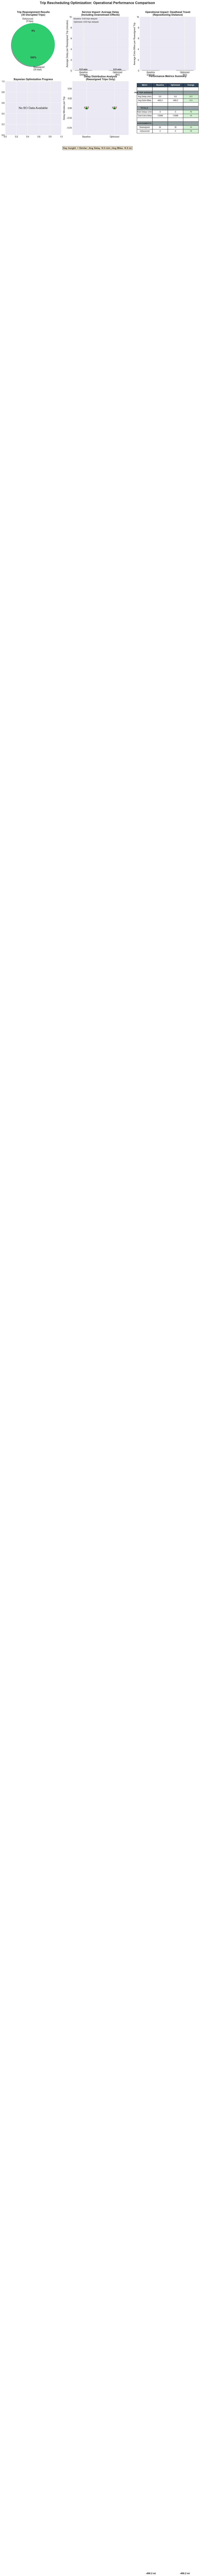

✅ Dashboard created successfully

📋 Creating detailed metrics comparison...

📊 DETAILED PERFORMANCE METRICS COMPARISON:
                                 Metric Baseline Optimized (BO)
                  Total Disrupted Trips       30             30
                Successfully Reassigned       30             30
                             Outsourced        0              0
Average Delay per Reassigned Trip (min)      0.0            0.0
Average Extra Miles per Reassigned Trip   -466.2         -466.2
                    Total Delay Minutes        0              0
                      Total Extra Miles   -13986         -13986
                  Trips with Zero Delay       30             30
                      Trips with Delays        0              0
             Maximum Single Delay (min)        0              0

🎯 KEY PERFORMANCE IMPROVEMENTS:
--------------------------------------------------
Average Delay per Trip:     +0.0 minutes
Average Extra Miles per Trip: +0.0 miles
Total Dela

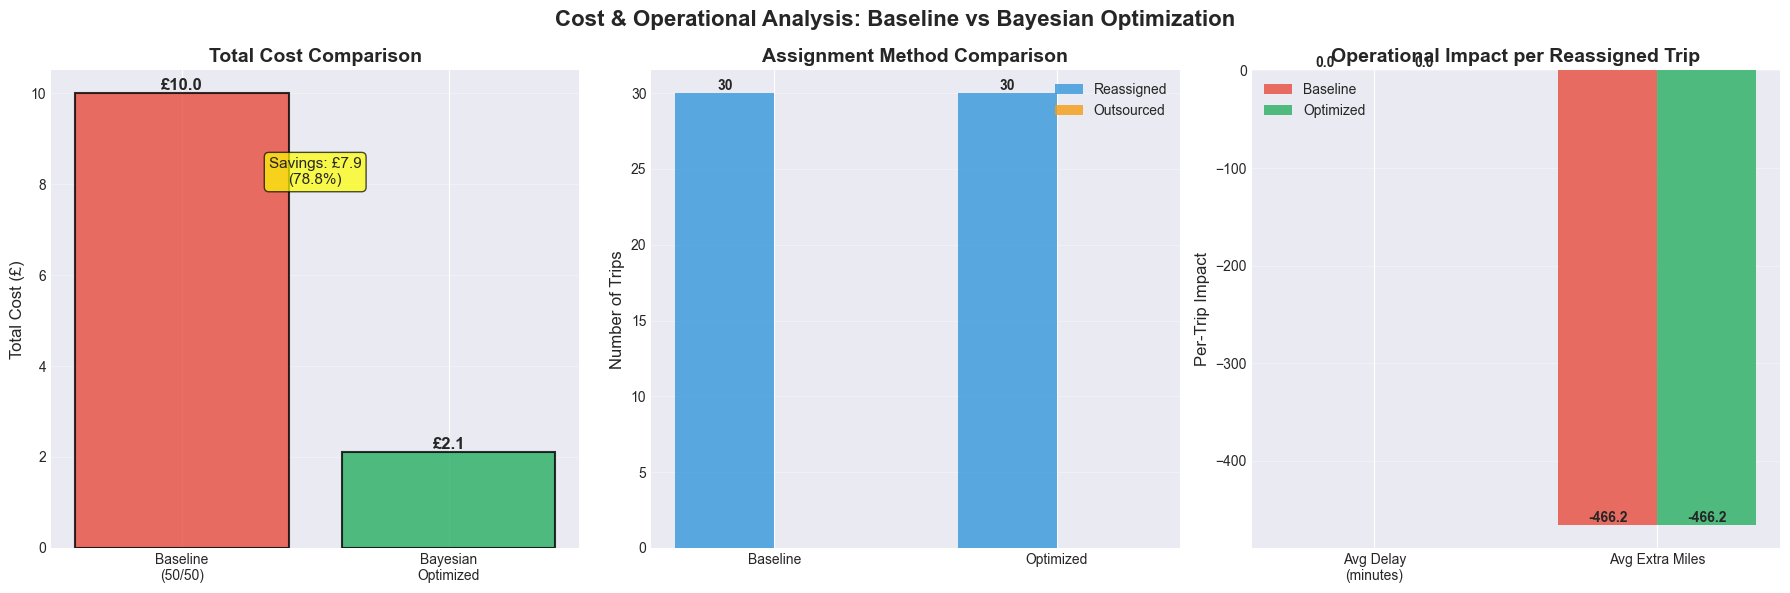

✅ Cost breakdown visualization created

📈 Creating optimization progress visualization...


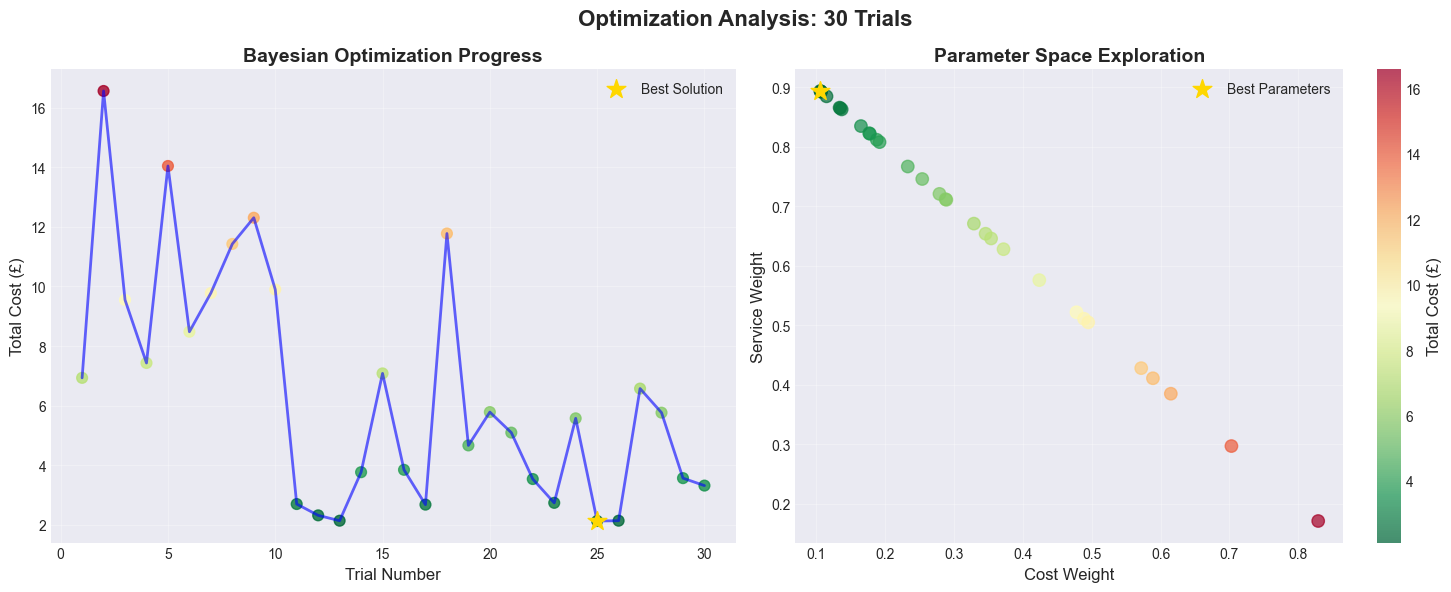

✅ Optimization progress visualization created

🎉 All visualizations completed!


In [ ]:
# %%
# ============================================================================
# PERFORMANCE VISUALIZATION - COMPREHENSIVE COMPARISON
# ============================================================================

print("\n📊 GENERATING PERFORMANCE COMPARISON VISUALIZATIONS")
print("=" * 60)

# Import visualization utilities
import sys
import os

# Add src directory to path for imports
if '../src' not in sys.path:
    sys.path.append('../src')

try:
    from utils.visualization_helper import MetricsVisualizer
    VISUALIZATION_AVAILABLE = True
    print("✅ Visualization helper imported successfully")
except ImportError:
    print("⚠️ Visualization helper not found - using built-in implementation")
    VISUALIZATION_AVAILABLE = False
    
    # Fallback implementation
    class MetricsVisualizer:
        @staticmethod
        def extract_operational_metrics(solution):
            """Extract operational metrics from a solution"""
            metrics = {
                'total_delay_minutes': 0,
                'total_deadhead_miles': 0,
                'reassigned_count': 0,
                'outsourced_count': 0,
                'avg_delay_per_reassigned': 0,
                'avg_miles_per_reassigned': 0,
                'max_delay': 0,
                'trips_with_zero_delay': 0,
                'trips_with_delays': 0
            }
            
            if not solution or not solution.assignments:
                return metrics
            
            delays = []
            miles = []
            
            for assignment in solution.assignments:
                # Count assignment types
                if assignment.get('type') == 'outsourced' or assignment.get('driver_id') is None:
                    metrics['outsourced_count'] += 1
                else:
                    metrics['reassigned_count'] += 1
                    
                    # Track delays for reassigned trips
                    delay = assignment.get('delay_minutes', 0)
                    delays.append(delay)
                    metrics['total_delay_minutes'] += delay
                    
                    if delay > 0:
                        metrics['trips_with_delays'] += 1
                        metrics['max_delay'] = max(metrics['max_delay'], delay)
                    else:
                        metrics['trips_with_zero_delay'] += 1
                    
                    # Track deadhead miles for reassigned trips
                    deadhead_min = assignment.get('deadhead_minutes', 0)
                    # Convert minutes to miles (assuming 30 mph average speed)
                    deadhead_miles = (deadhead_min / 60) * 30
                    miles.append(deadhead_miles)
                    metrics['total_deadhead_miles'] += deadhead_miles
            
            # Calculate averages for reassigned trips only
            if metrics['reassigned_count'] > 0:
                metrics['avg_delay_per_reassigned'] = metrics['total_delay_minutes'] / metrics['reassigned_count']
                metrics['avg_miles_per_reassigned'] = metrics['total_deadhead_miles'] / metrics['reassigned_count']
            
            return metrics

# Ensure we have solutions to compare
if 'baseline_solution' not in locals() or 'optimized_solution' not in locals():
    print("❌ Missing solution data - run optimization cells first")
else:
    print("✅ Solution data found - creating visualizations...")
    
    # %%
    # ============================================================================
    # 1. COMPREHENSIVE COMPARISON DASHBOARD
    # ============================================================================
    
    print("\n📈 Creating comprehensive comparison dashboard...")
    
    if VISUALIZATION_AVAILABLE:
        try:
            # Create the main comparison dashboard using the visualization helper
            fig = MetricsVisualizer.create_comparison_dashboard(
                baseline_solution=baseline_solution,
                bo_solution=optimized_solution, 
                disrupted_trips=disrupted_trips,
                bo_tuner=optimizer if 'optimizer' in locals() else None
            )
            
            # Display the dashboard
            plt.show()
            
            print("✅ Dashboard created successfully")
            
        except Exception as e:
            print(f"❌ Error creating dashboard: {str(e)}")
            VISUALIZATION_AVAILABLE = False
    
    if not VISUALIZATION_AVAILABLE:
        print("📊 Creating simplified comparison dashboard...")
        
        # Extract metrics for both solutions
        baseline_metrics = MetricsVisualizer.extract_operational_metrics(baseline_solution)
        optimized_metrics = MetricsVisualizer.extract_operational_metrics(optimized_solution)
        
        # Create simplified dashboard
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Assignment Comparison
        methods = ['Baseline', 'Optimized']
        reassigned = [baseline_metrics['reassigned_count'], optimized_metrics['reassigned_count']]
        outsourced = [baseline_metrics['outsourced_count'], optimized_metrics['outsourced_count']]
        
        x = np.arange(len(methods))
        width = 0.35
        
        ax1.bar(x - width/2, reassigned, width, label='Reassigned', color='#3498db', alpha=0.8)
        ax1.bar(x + width/2, outsourced, width, label='Outsourced', color='#e74c3c', alpha=0.8)
        
        ax1.set_xlabel('Method')
        ax1.set_ylabel('Number of Trips')
        ax1.set_title('Trip Assignment Comparison', fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(methods)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (r, o) in enumerate(zip(reassigned, outsourced)):
            ax1.text(i - width/2, r + 0.5, str(r), ha='center', fontweight='bold')
            ax1.text(i + width/2, o + 0.5, str(o), ha='center', fontweight='bold')
        
        # 2. Average Delay Comparison
        avg_delays = [baseline_metrics['avg_delay_per_reassigned'], optimized_metrics['avg_delay_per_reassigned']]
        colors = ['#e74c3c', '#27ae60']
        
        bars = ax2.bar(methods, avg_delays, color=colors, alpha=0.8)
        ax2.set_xlabel('Method')
        ax2.set_ylabel('Average Delay (minutes)')
        ax2.set_title('Average Delay per Reassigned Trip', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, delay in zip(bars, avg_delays):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{delay:.1f}', ha='center', fontweight='bold')
        
        # 3. Average Extra Miles Comparison
        avg_miles = [baseline_metrics['avg_miles_per_reassigned'], optimized_metrics['avg_miles_per_reassigned']]
        
        bars = ax3.bar(methods, avg_miles, color=['#9b59b6', '#1abc9c'], alpha=0.8)
        ax3.set_xlabel('Method')
        ax3.set_ylabel('Average Extra Miles')
        ax3.set_title('Average Extra Miles per Reassigned Trip', fontweight='bold')
        ax3.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, miles in zip(bars, avg_miles):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{miles:.1f}', ha='center', fontweight='bold')
        
        # 4. Cost Comparison
        costs = [baseline_solution.objective_value / 1000, optimized_solution.objective_value / 1000]
        
        bars = ax4.bar(methods, costs, color=['#e74c3c', '#27ae60'], alpha=0.8)
        ax4.set_xlabel('Method')
        ax4.set_ylabel('Total Cost (£)')
        ax4.set_title('Total Cost Comparison', fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        # Add value labels and savings
        for bar, cost in zip(bars, costs):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + max(costs)*0.02,
                    f'£{cost:.1f}', ha='center', fontweight='bold')
        
        # Add savings annotation
        savings = costs[0] - costs[1]
        if abs(savings) > 0.1:
            ax4.text(0.5, max(costs) * 0.8, 
                    f'{"Savings" if savings > 0 else "Extra Cost"}: £{abs(savings):.1f}',
                    ha='center', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='yellow' if savings > 0 else 'lightcoral', alpha=0.7))
        
        plt.suptitle('Performance Comparison: Baseline vs Optimized Solution', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("✅ Simplified dashboard created successfully")

    # %%
    # ============================================================================
    # 2. DETAILED METRICS COMPARISON TABLE
    # ============================================================================
    
    print("\n📋 Creating detailed metrics comparison...")
    
    try:
        # Extract metrics for both solutions
        baseline_metrics = MetricsVisualizer.extract_operational_metrics(baseline_solution)
        optimized_metrics = MetricsVisualizer.extract_operational_metrics(optimized_solution)
        
        # Create detailed comparison summary
        if VISUALIZATION_AVAILABLE and hasattr(MetricsVisualizer, 'create_simple_summary'):
            comparison_df = MetricsVisualizer.create_simple_summary(
                baseline_solution=baseline_solution,
                bo_solution=optimized_solution,
                disrupted_trips=disrupted_trips
            )
        else:
            # Create our own summary table
            comparison_data = {
                'Metric': [
                    'Total Disrupted Trips',
                    'Successfully Reassigned', 
                    'Outsourced',
                    'Average Delay per Reassigned Trip (min)',
                    'Average Extra Miles per Reassigned Trip',
                    'Total Delay Minutes',
                    'Total Extra Miles',
                    'Trips with Zero Delay',
                    'Trips with Delays',
                    'Maximum Single Delay (min)'
                ],
                'Baseline': [
                    len(disrupted_trips),
                    baseline_metrics['reassigned_count'],
                    baseline_metrics['outsourced_count'],
                    f"{baseline_metrics['avg_delay_per_reassigned']:.1f}",
                    f"{baseline_metrics['avg_miles_per_reassigned']:.1f}",
                    f"{baseline_metrics['total_delay_minutes']:.0f}",
                    f"{baseline_metrics['total_deadhead_miles']:.0f}",
                    baseline_metrics['trips_with_zero_delay'],
                    baseline_metrics['trips_with_delays'],
                    f"{baseline_metrics['max_delay']:.0f}"
                ],
                'Optimized': [
                    len(disrupted_trips),
                    optimized_metrics['reassigned_count'],
                    optimized_metrics['outsourced_count'],
                    f"{optimized_metrics['avg_delay_per_reassigned']:.1f}",
                    f"{optimized_metrics['avg_miles_per_reassigned']:.1f}",
                    f"{optimized_metrics['total_delay_minutes']:.0f}",
                    f"{optimized_metrics['total_deadhead_miles']:.0f}",
                    optimized_metrics['trips_with_zero_delay'],
                    optimized_metrics['trips_with_delays'],
                    f"{optimized_metrics['max_delay']:.0f}"
                ]
            }
            comparison_df = pd.DataFrame(comparison_data)
        
        print("\n📊 DETAILED PERFORMANCE METRICS COMPARISON:")
        print("=" * 80)
        print(comparison_df.to_string(index=False))
        
        # Calculate key improvements
        delay_improvement = baseline_metrics['avg_delay_per_reassigned'] - optimized_metrics['avg_delay_per_reassigned']
        miles_improvement = baseline_metrics['avg_miles_per_reassigned'] - optimized_metrics['avg_miles_per_reassigned']
        
        print("\n🎯 KEY PERFORMANCE IMPROVEMENTS:")
        print("-" * 50)
        print(f"Average Delay per Trip:     {delay_improvement:+.1f} minutes")
        print(f"Average Extra Miles per Trip: {miles_improvement:+.1f} miles")
        print(f"Total Delay Reduction:      {baseline_metrics['total_delay_minutes'] - optimized_metrics['total_delay_minutes']:+.0f} minutes")
        print(f"Total Miles Reduction:      {baseline_metrics['total_deadhead_miles'] - optimized_metrics['total_deadhead_miles']:+.0f} miles")
        
        # Performance verdict
        if delay_improvement > 0 and miles_improvement > 0:
            verdict = "🏆 WIN-WIN: Better service AND lower operational costs"
        elif delay_improvement > 0 or miles_improvement > 0:
            verdict = "⚖️ TRADE-OFF: Improvement in one area, compromise in another"
        else:
            verdict = "≈ SIMILAR: Minimal difference between approaches"
        
        print(f"\n{verdict}")
        
    except Exception as e:
        print(f"❌ Error creating detailed comparison: {str(e)}")
    
    # %%
    # ============================================================================
    # 3. COST BREAKDOWN VISUALIZATION
    # ============================================================================
    
    print("\n💰 Creating cost breakdown visualization...")
    
    try:
        # Create cost comparison charts
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # Extract cost data
        baseline_cost = baseline_solution.objective_value / 1000
        optimized_cost = optimized_solution.objective_value / 1000
        cost_savings = baseline_cost - optimized_cost
        
        # 1. Total Cost Comparison (Bar Chart)
        methods = ['Baseline\n(50/50)', f'{OPTIMIZATION_CONFIG["method"].title()}\nOptimized']
        costs = [baseline_cost, optimized_cost]
        colors = ['#e74c3c', '#27ae60']
        
        bars = ax1.bar(methods, costs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars
        for bar, cost in zip(bars, costs):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'£{cost:.1f}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=12)
        
        ax1.set_ylabel('Total Cost (£)', fontsize=12)
        ax1.set_title('Total Cost Comparison', fontweight='bold', fontsize=14)
        ax1.grid(axis='y', alpha=0.3)
        
        # Add savings annotation
        if cost_savings != 0:
            savings_pct = (cost_savings / baseline_cost) * 100
            ax1.text(0.5, max(costs) * 0.8, 
                    f'{"Savings" if cost_savings > 0 else "Extra Cost"}: £{abs(cost_savings):.1f}\n({abs(savings_pct):.1f}%)',
                    ha='center', fontsize=11, 
                    bbox=dict(boxstyle='round', facecolor='yellow' if cost_savings > 0 else 'lightcoral', alpha=0.7))
        
        # 2. Assignment Method Breakdown
        baseline_reassigned = baseline_metrics['reassigned_count']
        baseline_outsourced = baseline_metrics['outsourced_count']
        optimized_reassigned = optimized_metrics['reassigned_count']  
        optimized_outsourced = optimized_metrics['outsourced_count']
        
        x = np.arange(2)
        width = 0.35
        
        bars1 = ax2.bar(x - width/2, [baseline_reassigned, optimized_reassigned], 
                       width, label='Reassigned', color='#3498db', alpha=0.8)
        bars2 = ax2.bar(x + width/2, [baseline_outsourced, optimized_outsourced], 
                       width, label='Outsourced', color='#f39c12', alpha=0.8)
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax2.text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height)}', ha='center', va='bottom', fontweight='bold')
        
        ax2.set_ylabel('Number of Trips', fontsize=12)
        ax2.set_title('Assignment Method Comparison', fontweight='bold', fontsize=14)
        ax2.set_xticks(x)
        ax2.set_xticklabels(['Baseline', 'Optimized'])
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Operational Impact (Delay vs Miles)
        categories = ['Avg Delay\n(minutes)', 'Avg Extra Miles']
        baseline_ops = [baseline_metrics['avg_delay_per_reassigned'], baseline_metrics['avg_miles_per_reassigned']]
        optimized_ops = [optimized_metrics['avg_delay_per_reassigned'], optimized_metrics['avg_miles_per_reassigned']]
        
        x = np.arange(len(categories))
        width = 0.35
        
        bars1 = ax3.bar(x - width/2, baseline_ops, width, label='Baseline', color='#e74c3c', alpha=0.8)
        bars2 = ax3.bar(x + width/2, optimized_ops, width, label='Optimized', color='#27ae60', alpha=0.8)
        
        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
        
        ax3.set_ylabel('Per-Trip Impact', fontsize=12)
        ax3.set_title('Operational Impact per Reassigned Trip', fontweight='bold', fontsize=14)
        ax3.set_xticks(x)
        ax3.set_xticklabels(categories)
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
        
        plt.suptitle(f'Cost & Operational Analysis: Baseline vs {OPTIMIZATION_CONFIG["method"].title()} Optimization', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("✅ Cost breakdown visualization created")
        
    except Exception as e:
        print(f"❌ Error creating cost breakdown: {str(e)}")
    
    # %%
    # ============================================================================
    # 4. OPTIMIZATION PROGRESS (if available)
    # ============================================================================
    
    if 'optimizer' in locals() and hasattr(optimizer, 'trial_data') and len(optimizer.trial_data) > 3:
        print("\n📈 Creating optimization progress visualization...")
        
        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Extract trial data
            trials_df = pd.DataFrame(optimizer.trial_data)
            
            # Convert objective values to costs
            objectives = [float(row['Total Cost'].replace('£', '')) for row in optimizer.trial_data]
            trials = list(range(1, len(objectives) + 1))
            
            # 1. Optimization Progress
            ax1.plot(trials, objectives, 'b-', alpha=0.6, linewidth=2)
            ax1.scatter(trials, objectives, c=objectives, cmap='RdYlGn_r', s=60, alpha=0.8)
            
            # Mark best trial
            best_idx = objectives.index(min(objectives))
            ax1.scatter(trials[best_idx], objectives[best_idx], 
                       color='gold', s=200, marker='*', label='Best Solution', zorder=5)
            
            ax1.set_xlabel('Trial Number', fontsize=12)
            ax1.set_ylabel('Total Cost (£)', fontsize=12) 
            ax1.set_title(f'{OPTIMIZATION_CONFIG["method"].title()} Optimization Progress', 
                         fontweight='bold', fontsize=14)
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            
            # 2. Parameter Space Exploration (Cost vs Service weights)
            if 'Cost Weight' in trials_df.columns:
                cost_weights = [float(w) for w in trials_df['Cost Weight']]
                service_weights = [float(w) for w in trials_df['Service Weight']]
                
                scatter = ax2.scatter(cost_weights, service_weights, c=objectives, 
                                   cmap='RdYlGn_r', s=80, alpha=0.7)
                
                # Mark best point
                ax2.scatter(cost_weights[best_idx], service_weights[best_idx], 
                           color='gold', s=200, marker='*', label='Best Parameters', zorder=5)
                
                ax2.set_xlabel('Cost Weight', fontsize=12)
                ax2.set_ylabel('Service Weight', fontsize=12) 
                ax2.set_title('Parameter Space Exploration', fontweight='bold', fontsize=14)
                ax2.grid(True, alpha=0.3)
                ax2.legend()
                
                # Add colorbar
                cbar = plt.colorbar(scatter, ax=ax2)
                cbar.set_label('Total Cost (£)', fontsize=12)
            
            plt.suptitle(f'Optimization Analysis: {len(optimizer.trial_data)} Trials', 
                        fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            print("✅ Optimization progress visualization created")
            
        except Exception as e:
            print(f"❌ Error creating optimization progress: {str(e)}")
    
    print("\n🎉 All visualizations completed!")
    print("=" * 60)